In [2]:
import sys
import cv2
import numpy as np
import math
import time
import os
import mediapipe as mp
from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QVBoxLayout, QWidget, QSizePolicy, QLineEdit, QMessageBox
from PyQt5 import QtCore, QtWidgets, QtGui
import pyttsx3
from PyQt5.QtCore import QTimer, Qt
import threading
import queue
from PyQt5.QtGui import QImage, QPixmap, QPainter, QFont, QColor


# 抬胳膊demo

In [3]:
class PoseApp(QMainWindow):

    def __init__(self):
        super().__init__()
        self.setWindowTitle("直腿抬高")
        self.subject_id = ""
        
        self.input_label = QLabel("请输入受试者编号:")
        self.subject_input = QLineEdit()
        self.start_button = QPushButton("开始检测")
        self.start_button.clicked.connect(self.start_detection)
        
        # 用于显示摄像头画面的标签
        self.video_label = QLabel()
        self.video_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        self.video_label.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.video_label.setScaledContents(True)
        
        layout = QVBoxLayout()
        layout.addWidget(self.input_label)
        layout.addWidget(self.subject_input)
        layout.addWidget(self.start_button)
        layout.addWidget(self.video_label)

        
        container = QWidget()
        container.setLayout(layout)
        self.setCentralWidget(container)
        
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose()
        self.mp_drawing = mp.solutions.drawing_utils
        self.engine = pyttsx3.init()
        
        self.speech_queue = queue.Queue()
        self.speech_thread = threading.Thread(target=self.speech_loop, daemon=True)
        self.speech_thread.start()
        self.speech_in_progress = False
        
        self.cap = None
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_frame)
        
        self.last_time = time.time()
        self.hip_angle_history = []
        self.leg_raised = False
        
        self.left_leg_prompted = False
    
        self.count_good = 0
        self.count_bad = 0
        self.stage = None  # 'up' or 'down'

        # 阈值设定
        self.ANGLE_MIN = 40    # 手臂最低角度
        self.ANGLE_MAX = 160   # 手臂最高角度

        self.calibrated = False
        self.calibration_count = 0
        self.calibration_frames_required = 30   # 连续多少帧满足水平即算校准成功

        # 校准框，按比例定义（比如画在画面中间高度 40%~60% 区域）
        self.box_y1 = 0.4
        self.box_y2 = 0.6

        self.stage = 'rest'     #  'rest'（初始/伸直→准备弯曲）、  
                        #          'bending'（已经弯曲到位→等待伸直）、  
                        #          b 'rest'（伸直到位→可以再弯曲一次）
        self.rep_count = 0 


    def speech_loop(self):
        """
        后台线程负责真正的 TTS 初始化和播报。每次从队列取到文本，
        都在同一个局部 engine 对象上调用 say/runAndWait，
        并在播报后把 speech_in_progress 置回 False。
        """
        # 在后台线程中独立初始化 engine
        engine = pyttsx3.init()
        while True:
            text = self.speech_queue.get()
            if text is None:  # 收到退出信号
                break
            try:
                engine.say(text)
                engine.runAndWait()
            except Exception:
                # 捕获任何底层异常，防止崩溃
                import traceback
                traceback.print_exc()
            finally:
                # 播报完毕或出错后都要重置标记
                self.speech_in_progress = False
                self.speech_queue.task_done()

    def speak(self, message):
        """
        只在主线程（update_frame）中调用，将 message 放到队列；不直接 runAndWait。
        后台线程拿到后才真正调用 engine.runAndWait()。
        """
        if self.speech_in_progress:
            return
        self.speech_in_progress = True
        self.speech_queue.put(message)


    def calculate_angle(self, a, b, c):
        # 计算三点之间的夹角
        ab = [b[0] - a[0], b[1] - a[1]]
        bc = [c[0] - b[0], c[1] - b[1]]
        dot_product = ab[0] * bc[0] + ab[1] * bc[1]
        cross_product = ab[0] * bc[1] - ab[1] * bc[0]
        angle = math.degrees(math.atan2(abs(cross_product), dot_product))
        return angle

    def start_detection(self):
        # 获取受试者编号，并启动摄像头检测
        self.subject_id = self.subject_input.text().strip()
        if not self.subject_id:
            QMessageBox.warning(self, "警告", "请输入受试者编号!")
            return
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            QMessageBox.critical(self, "错误", "无法打开摄像头!")
            return
        self.timer.start(30)  # 每30毫秒更新一次画面
        self.start_button.setEnabled(False)
        self.subject_input.setEnabled(False)

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return
    
        h, w = frame.shape[:2]
        feedback = ""
        elbow_angle = 0

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.pose.process(frame_rgb)
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            right_shoulder = (landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                             landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y)
            right_elbow = (landmarks[self.mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                        landmarks[self.mp_pose.PoseLandmark.RIGHT_ELBOW.value].y)
            right_wrist = (landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST.value].x,   
                           landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST.value].y)
            
            # 校准框线
            sx = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER].x * w)
            sy = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER].y * h)
            ex = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_ELBOW].x    * w)
            ey = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_ELBOW].y    * h)
            wx = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST].x    * w)
            wy = int(landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST].y    * h)

            cv2.line(frame, (sx, sy), (ex, ey), (0,255,0), 2)
            cv2.line(frame, (ex, ey), (wx, wy), (0,255,0), 2)
            cv2.circle(frame, (sx, sy), 5, (0,0,255), -1)
            cv2.circle(frame, (ex, ey), 5, (0,255,255), -1)
            cv2.circle(frame, (wx, wy), 5, (255,0,0), -1)

            cv2.line(frame, (int(right_shoulder[0] * frame.shape[1]), int(right_shoulder[1] * frame.shape[0])), 
                     (int(right_elbow[0] * frame.shape[1]), int(right_elbow[1] * frame.shape[0])), (0, 255, 0), 2)
            cv2.line(frame, (int(right_elbow[0] * frame.shape[1]), int(right_elbow[1] * frame.shape[0])), 
                     (int(right_wrist[0] * frame.shape[1]), int(right_wrist[1] * frame.shape[0])), (0, 255, 0), 2)

            cv2.circle(frame, (int(right_shoulder[0] * frame.shape[1]), int(right_shoulder[1] * frame.shape[0])), 5, (0, 0, 255), -1)
            cv2.circle(frame, (int(right_elbow[0] * frame.shape[1]), int(right_elbow[1] * frame.shape[0])), 5, (0, 255, 255), -1)
            cv2.circle(frame, (int(right_wrist[0] * frame.shape[1]), int(right_wrist[1] * frame.shape[0])), 5, (255, 0, 0), -1)
            

            elbow_angle = self.calculate_angle(right_shoulder, right_elbow, right_wrist)
            elbow_angle = 180 - elbow_angle  


            # if self.speech_in_progress:
            #     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #     h, w, ch = frame.shape
            #     bytes_per_line = ch * w
            #     q_img = QImage(frame_rgb.data, w, h, bytes_per_line, QImage.Format.Format_RGB888)
            #     self.video_label.setPixmap(QPixmap.fromImage(q_img))
            #     return
            

            # —— 校准 ——
            if not self.calibrated:
                # 画校准框
                y1 = int(self.box_y1 * h)
                y2 = int(self.box_y2 * h)
                cv2.rectangle(frame, (0, y1), (w, y2), (255,255,0), 2)
                # 判断三点是否都在框内，且 y 相差在 ±10px 内（水平）
                if y1 < sy < y2 and y1 < ey < y2 and y1 < wy < y2 \
                   and abs(sy - ey) < 10 and abs(ey - wy) < 10:
                    self.calibration_count += 1
                    feedback = f"校准中:{self.calibration_count}/{self.calibration_frames_required}"
                    if self.calibration_count >= self.calibration_frames_required:
                        self.calibrated = True
                        feedback = "校准成功，开始跟练"
                        try:
                            self.speak(feedback)
                        except:
                            pass
                else:
                    self.calibration_count = 0
                    feedback = "请将手臂水平放入框内"

            else:            

                # elbow_angle = self.calculate_angle(right_shoulder, right_elbow, right_wrist)
                # elbow_angle = 180 - elbow_angle  

                # —— 状态机——
                if elbow_angle > self.ANGLE_MAX:
                    # 完全伸直到位
                    if self.stage == 'bending':
                        # 从弯曲回到伸直，完成一次
                        self.rep_count += 1
                    self.stage = 'rest'
                    feedback = "伸直就绪"
                elif elbow_angle < self.ANGLE_MIN:
                    # 完全弯曲到位
                    if self.stage == 'rest':
                        # 从伸直到弯曲，进入弯曲阶段
                        self.stage = 'bending'
                    feedback = "请弯曲"
                else:
                    feedback = "保持"
                # —— 结束 —— 

            cv2.putText(frame, f"elbow: {elbow_angle:.2f}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, ch = frame_rgb.shape
        bytes_per_line = ch * w
        q_img = QImage(frame_rgb.data, w, h, bytes_per_line, QImage.Format.Format_RGB888)

        pix = QPixmap.fromImage(q_img)

        #用 QPainter 在 pixmap 上画中文
        painter = QPainter(pix)
        painter.setPen(QColor(255, 0, 0))               
        font = QFont("Microsoft YaHei", 24)             
        painter.setFont(font)
        painter.drawText(40, 60, feedback)
        painter.drawText(60, 80, f"完成次数：{self.rep_count}")
              
        painter.end()

        self.video_label.setPixmap(pix)

        
    def closeEvent(self, event):
        self.timer.stop()
        if self.cap is not None:
            self.cap.release()
        cv2.destroyAllWindows()
        # 通知语音线程退出
        self.speech_queue.put(None)
        event.accept()

if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = PoseApp()
    window.show()
    sys.exit(app.exec())

I0000 00:00:1748929632.986944 2441245 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748929633.061021 2441368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748929633.072869 2441371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
2025-06-03 13:47:14.829 python[48740:2441245] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit
2025-06-03 13:47:15.254 python[48740:2441245] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
qt.qpa.fonts: Populating font family aliases took 112 ms. Replace uses of missing font family 

SystemExit: 0

/Users/zehaokou/miniconda3/envs/rehab/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 初级单腿硬拉

I0000 00:00:1748590433.228508  172247 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748590433.319002  172438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748590433.331224  172437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
2025-05-30 15:33:54.373 python[4812:172247] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-30 15:33:54.373 python[4812:172247] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-05-30 15:33:55.234 python[4812:172247] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit
2025-05-30 15:33:55.238 python[4812:172247] error messaging the mach port for IMKCFRunLoopWakeUpReliable
2025-05-30 15:33:55.888 python[48

SystemExit: 0

/Users/zehaokou/miniconda3/envs/rehab/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


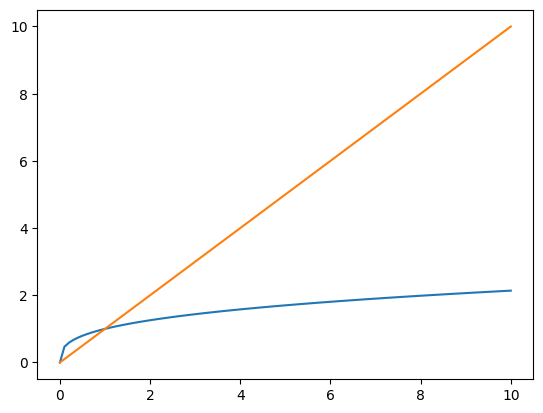

In [6]:
# draw a power function 
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 10, 100)
y1 = x**0.33
y2 = x**1

plt.plot(x, y1)
plt.plot(x, y2)